### Import requirement library

In [1]:
from math import ceil
import numpy as np 
import cvxpy as cp 
import random
import matplotlib.pyplot as plt
from deepc import DeePC
from numpy import linalg
import pandas as pd


### Collect Data

In [8]:
# Define system
A = np.array([[1.01,0.01,0],[0.01,1.01,0.01],[0,0.01,1.01]])
B = np.eye(3)
C = np.eye(3)
(n,m) = B.shape                                 # n = number of states, m = number of inputs
p = n                                           # p = number of output
        
# Simulation    
x0 = np.array([[0],[0],[1]])
t_step = 0.1
t_sim = 4.3                                    # simulation time 
n_sim = ceil(t_sim/t_step)                     # Number of simulation step n_sim >= (m+1)*(T_ini + N + n(B)) - 1
x = x0 
xData = np.empty((n,n_sim+1))
yData = np.empty((n,n_sim+1))
xData[:,[0]] = x0
yData[:,[0]] = x0
uData = np.empty((m,n_sim))

# Generate random input sequence
np.random.seed(1)
u_seq = np.array(np.random.rand(m,n_sim))
# measurement noise
mu = 0 #0.5
sigma = 0.2 # 0.2

# Collect data
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData[:,[t]] = u 
    xData[:,[t+1]] = x
    yData[:,[t+1]] = y

### Create DeePC controller

In [9]:
# set parameters
params = {}
params['uData'] = uData
params['yData'] = yData[:,1:] #xData[:,1:]
params['N'] = 5
params['Q'] = np.eye(3)
params['R'] = np.eye(3)*10
params['lambda_slack'] = 10**7# 10**7
params['lambda_g'] = 300# 100

# create controller    
controller = DeePC(params)
# controller.create_Hankel_check()

# offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  

33
(33, 33)
We are good to go!!
[[4.17022005e-01 7.20324493e-01 1.14374817e-04 ... 5.33165285e-01
  6.91877114e-01 3.15515631e-01]
 [7.89279328e-01 1.03226007e-01 4.47893526e-01 ... 9.27508580e-01
  3.47765860e-01 7.50812103e-01]
 [4.28091190e-01 9.64840047e-01 6.63441498e-01 ... 1.24270962e-01
  1.98801338e-02 2.62109869e-02]
 ...
 [2.47134243e+00 3.38979440e+00 3.58572910e+00 ... 2.91193334e+01
  3.05499290e+01 3.17385593e+01]
 [3.39735180e+00 4.26329799e+00 5.13089330e+00 ... 3.59264627e+01
  3.71260586e+01 3.91348026e+01]
 [6.30166471e+00 6.62082024e+00 6.96919856e+00 ... 3.36908584e+01
  3.56511724e+01 3.62721679e+01]]
(48, 36)
36


### Generate Initial State

In [10]:
# Simulation    
x0 = np.array([[-20],[5],[1]])
t_step = 0.1
t_sim = 1.0;                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0; 
xData_ini = np.empty((n,n_sim+1)); 
xData_ini[:,[0]] = x0; 
uData_ini = np.empty((m,n_sim));
    
# Generate random input sequence
np.random.seed(5)
u_seq = np.array(np.random.rand(m,n_sim))

# Collect data
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    x = x + w
    uData_ini[:,[t]] = u 
    xData_ini[:,[t+1]] = x

### Simulation

In [11]:
# Simulation    
x0 = xData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(xData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 10.0;                                  # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))
    
# run simulation
for t in range(n_sim):
    u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
    # u = np.zeros((m,1))
    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = x + w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    costLog[0,[t]] = cost
    y = x_vec
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y]])

[[-1.50952133e-01]
 [-3.74316619e-05]
 [ 3.62448260e-05]
 [ 5.90100981e-06]
 [ 4.51214464e+00]
 [ 1.43376827e+00]
 [ 4.87697367e+00]
 [ 1.06413949e+00]
 [ 2.36725219e+00]
 [ 2.20792978e+00]
 [ 2.60275280e+00]
 [-9.32252433e-05]
 [ 8.58470990e-05]
 [-6.89686246e-05]
 [-1.80148497e-01]
 [ 1.57543936e-06]
 [-6.95539513e-01]
 [-1.44235083e-05]
 [ 6.94074495e-05]
 [-5.97705462e-05]
 [-1.67207643e+00]
 [-3.89029082e+00]
 [-6.92394475e+00]
 [-3.36306338e-01]
 [-9.12451373e-01]
 [-6.00318939e-02]
 [ 9.63113399e-05]
 [-5.20003353e-01]
 [-5.85834071e-05]
 [-1.38931502e-01]
 [-1.43131091e-01]
 [ 6.54362300e-01]
 [ 2.84996475e+00]
 [ 4.94531074e-05]
 [ 1.25049504e+00]
 [ 7.40858187e-01]]
[[-4.11472918e-05]
 [ 7.40912847e-05]
 [ 3.05123765e-05]
 [ 1.18245583e+00]
 [ 4.73107525e+00]
 [ 1.91761382e+00]
 [ 1.79147261e+00]
 [ 1.44735890e+00]
 [ 2.48347196e+00]
 [ 1.06430610e+00]
 [ 1.76913367e+00]
 [ 9.47052771e-01]
 [-1.62212424e-01]
 [ 9.31773807e-05]
 [-9.53641812e-03]
 [-6.75404520e-05]
 [ 5.447156

#### Plot Result

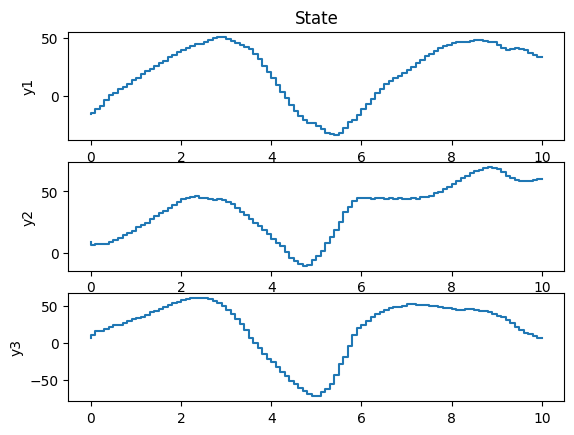

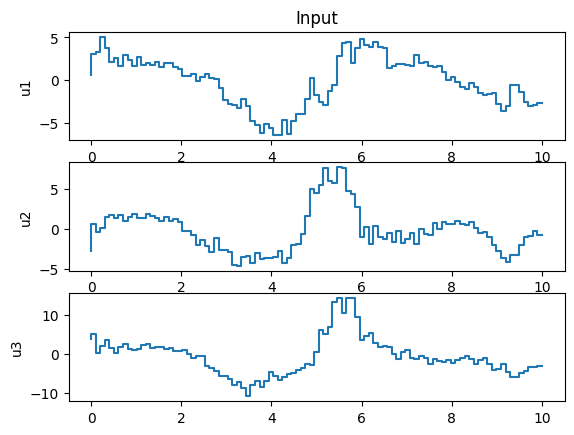

In [12]:
# Plot system evolution    
y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.step(time,xLog[0,:])
plt.ylabel('y1')
plt.title('State')

plt.subplot(312)
plt.step(time,xLog[1,:])   
plt.ylabel('y2')

plt.subplot(313)
plt.step(time,xLog[2,:])
plt.ylabel('y3')


# Plot input evolution    
u_plot = plt.figure(2)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.step(time,uLog[0,:])
plt.ylabel('u1')
plt.title('Input')

plt.subplot(312)
plt.step(time,uLog[1,:])   
plt.ylabel('u2')

plt.subplot(313)
plt.step(time,uLog[2,:])
plt.ylabel('u3')

plt.show()

#### Check

In [14]:
# Simulation    
x0 = xData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(xData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 0.5                                    # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))

(gg, uPred, yPred) = controller.computeDeePC(u_ini,y_ini)
   
# run simulation
for t in range(n_sim):
    u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = x + w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    costLog[0,[t]] = cost
    y = x_vec
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y]])

[[-4.95817086e-06]
 [ 1.83290625e-04]
 [ 1.19936995e-01]
 [-1.18486637e-05]
 [ 5.24420626e+00]
 [ 1.22351814e-01]
 [ 5.76216052e+00]
 [ 6.05669483e-01]
 [ 2.16780619e+00]
 [ 1.97812735e+00]
 [ 2.73682499e+00]
 [ 1.03604828e-05]
 [ 1.69718762e-05]
 [ 5.34515951e-05]
 [-3.67363101e-05]
 [-1.63857722e-05]
 [-7.71764245e-01]
 [-5.70869409e-05]
 [ 5.78743213e-05]
 [-5.22112155e-05]
 [-1.71439882e+00]
 [-3.85670543e+00]
 [-7.51676203e+00]
 [ 5.78392388e-05]
 [-1.07699678e+00]
 [-1.82783219e-01]
 [-3.62516785e-05]
 [-8.93662015e-02]
 [-1.26435078e-04]
 [-6.83326959e-04]
 [-4.75430194e-05]
 [ 3.25122043e-01]
 [ 3.98061358e+00]
 [ 5.63213691e-05]
 [ 6.26324584e-05]
 [ 1.04005488e+00]]
[[-4.95817086e-06]
 [ 1.83290625e-04]
 [ 1.19936995e-01]
 [-1.18486637e-05]
 [ 5.24420626e+00]
 [ 1.22351814e-01]
 [ 5.76216052e+00]
 [ 6.05669483e-01]
 [ 2.16780619e+00]
 [ 1.97812735e+00]
 [ 2.73682499e+00]
 [ 1.03604828e-05]
 [ 1.69718762e-05]
 [ 5.34515951e-05]
 [-3.67363101e-05]
 [-1.63857722e-05]
 [-7.717642

In [17]:
x = x0.reshape(m, 1)
xLogggg = np.zeros((3,params['N']))
for i in range(params['N']):
    u = uPred[n*i:n*i+n]
    x = A@x+B@u
    xLogggg[:,[i]] = x
    print(x)
print(xLogggg)

[[-15.71954944]
 [  5.17695355]
 [ 10.83256137]]
[[-11.54633885]
 [  6.71315409]
 [ 13.43313238]]
[[-0.18976949]
 [ 7.04782545]
 [12.55374407]]
[[ 5.52288659]
 [ 8.91835094]
 [20.2441634 ]]
[[12.97055457]
 [18.20935882]
 [24.73012598]]
[[-15.71954944 -11.54633885  -0.18976949   5.52288659  12.97055457]
 [  5.17695355   6.71315409   7.04782545   8.91835094  18.20935882]
 [ 10.83256137  13.43313238  12.55374407  20.2441634   24.73012598]]


In [16]:
print(uPred.reshape(3,-1, order='F'))
print(yPred.reshape(3,-1, order='F'))

[[-0.50338453  4.27863654 11.40490121  5.64407553  7.3032556 ]
 [-3.73800913  1.53330089  0.24867188  1.67640749  8.94415387]
 [ 4.33675413  2.44047587 -1.08085117  7.49440363  4.19433744]]
[[-15.9988941  -13.07348961  -0.31262303   5.35411903  11.32058717]
 [  7.6333002    6.17324855   8.14414871   6.41003787  18.63732617]
 [  8.37721289  11.849823     7.45684853  21.34213023  19.5328847 ]]


In [23]:
print(xLogggg - yPred.reshape(3,-1, order='F'))


[[ 0.27934467  1.52715075  0.12285354  0.16876756  1.6499674 ]
 [-2.45634665  0.53990555 -1.09632326  2.50831308 -0.42796735]
 [ 2.45534848  1.58330939  5.09689554 -1.09796683  5.19724128]]


#### Plot cost

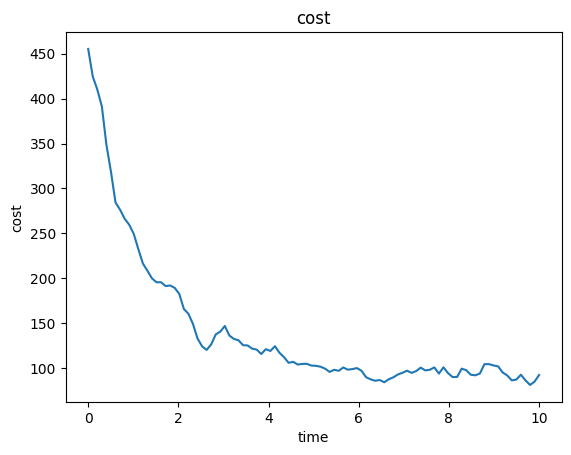

In [7]:
# Plot cost evolution    
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim)
plt.plot(time,costLog[0,:])
plt.ylabel('cost')
plt.xlabel('time')
plt.title('cost')

plt.show()

### Regularization

#### Iterate for lambda y

In [10]:

# Simulation   
lambda_List = [0.1,1,3,5,10,10**2,10**3,10**4,10**5,10**6,10**7] 
t_step = 0.1
t_sim = 5.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_g'] = 300

# run simulation
for i in range(len(lambda_List)):
    params['lambda_slack'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()     
    # init new log
    x0 = xData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(xData_ini[:,-n:],(-1, 1), order='F') 
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))

    for t in range(n_sim):
        u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        x = x + w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        costLog[0,[t]] = cost        
        y = x_vec
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y]])
    print(np.sum(costLog))
    sumcostLog[0,[i]] = np.sum(costLog)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

#### Iterate for lambda g

[[4.17022005e-01 7.20324493e-01 1.14374817e-04 ... 5.33165285e-01
  6.91877114e-01 3.15515631e-01]
 [7.89279328e-01 1.03226007e-01 4.47893526e-01 ... 9.27508580e-01
  3.47765860e-01 7.50812103e-01]
 [4.28091190e-01 9.64840047e-01 6.63441498e-01 ... 1.24270962e-01
  1.98801338e-02 2.62109869e-02]
 ...
 [2.47134243e+00 3.38979440e+00 3.58572910e+00 ... 2.91193334e+01
  3.05499290e+01 3.17385593e+01]
 [3.39735180e+00 4.26329799e+00 5.13089330e+00 ... 3.59264627e+01
  3.71260586e+01 3.91348026e+01]
 [6.30166471e+00 6.62082024e+00 6.96919856e+00 ... 3.36908584e+01
  3.56511724e+01 3.62721679e+01]]
(48, 36)
36
[[-0.9844055 ]
 [ 0.11357885]
 [ 1.14478348]
 [ 2.54254129]
 [ 2.96976106]
 [ 2.15856539]
 [ 3.07803514]
 [ 2.27476832]
 [ 3.14187724]
 [ 2.75229622]
 [ 1.45900335]
 [-0.43227104]
 [-0.42644915]
 [-0.68159935]
 [-1.88746197]
 [-0.78588525]
 [-2.31734564]
 [-0.44790681]
 [ 0.78578534]
 [-0.70227841]
 [-1.71638894]
 [-2.35876301]
 [-3.21975594]
 [-2.23346989]
 [-0.23638151]
 [-0.4674381 

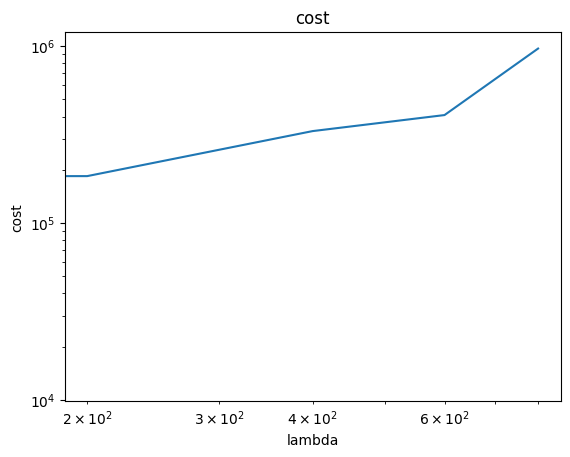

In [13]:
# Simulation   
lambda_List = [0,200,400,600,800] 
t_step = 0.1
t_sim = 5.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_slack'] = 10**7

# run simulation
for i in range(len(lambda_List)):
    params['lambda_g'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()     
    # init new log
    x0 = xData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(xData_ini[:,-n:],(-1, 1), order='F') 
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))

    for t in range(n_sim):
        u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        x = x + w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec # + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        costLog[0,[t]] = cost        
        y = x_vec
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y]])
    print(np.sum(costLog))
    sumcostLog[0,[i]] = np.sum(costLog)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()
